### For updated features based on the ppp_transformed_updated.csv

Transformations include:
- Converting Term from numeric/ordinal to categorical (less than 24, 24, between 24 and 60, 60, more than 60)
    - Justification: most concentrated around 24 and 60. the standard for ppp is 24 months, but can be extended to 60 months
    - Could also see it as whether a loan extension was applied
- Log transformation on large numeric variables
    - Normalises the data before standardising
    - MinMax shrinks the range but preserves the skew
    - shrinking 0-1B to 0-1 results in long decimals (eg. 0.988887622845627891), which usually gets binned together
    - new columns will be standardised as well
- Including dummy variables 
- Splitting dataset based on original (non-categorical), encoded, scaled_standardised, log_standardised, dummy

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 

from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("ppp_transformed_updated.csv")
df_original = df.copy()
df.columns

Index(['LoanNumber', 'DateApproved', 'SBAOfficeCode', 'ProcessingMethod',
       'BorrowerName', 'BorrowerCity', 'BorrowerState', 'BorrowerZip',
       'LoanStatus', 'Term', 'InitialApprovalAmount', 'CurrentApprovalAmount',
       'FranchiseName', 'ServicingLenderName', 'ServicingLenderZip',
       'RuralUrbanIndicator', 'HubzoneIndicator', 'LMIIndicator',
       'BusinessAgeDescription', 'ProjectCity', 'JobsReported', 'NAICSCode',
       'Race', 'Ethnicity', 'BusinessType', 'Gender', 'Veteran',
       'TOTAL_PROCEED', 'PROCEED_Diff', 'UTILITIES_PROCEED_pct',
       'PAYROLL_PROCEED_pct', 'MORTGAGE_INTEREST_PROCEED_pct',
       'RENT_PROCEED_pct', 'REFINANCE_EIDL_PROCEED_pct',
       'HEALTH_CARE_PROCEED_pct', 'DEBT_INTEREST_PROCEED_pct',
       'PROCEED_Per_Job', 'isAfterBiden', 'isDiffBorrowerAndProjectCity',
       'Industry', 'Subsector', 'ProcessingMethod_encoded',
       'LoanStatus_encoded', 'RuralUrbanIndicator_encoded',
       'HubzoneIndicator_encoded', 'LMIIndicator_encoded'

#### Converting 'Term' to categorical

In [3]:
def term_transform(row):
    """
    Transforms 'Term' column into a new column with categorical (string) values
    > 60  : more than 60
    == 60 : 60
    > 24  : between 24 and 60
    == 24 : 24
    < 24  : less than 24 
    """
    if row > 60:
        label = 'more_than_60'
    elif row == 60:
        label = 'is_60'
    elif row > 24:
        label = 'between_24_60'
    elif row == 24:
        label = 'is_24'
    else:
        label = 'less_than_24'
    return label

In [4]:
# transform Term column into categorical
df['Term_cat'] = df['Term'].apply(term_transform)
df[['Term', 'Term_cat']].head(5)

,Term,Term_cat
0,24,is_24
1,24,is_24
2,24,is_24
3,24,is_24
4,24,is_24


### Log-transform 'InitialApprovalAmount','CurrentApprovalAmount','TOTAL_PROCEED','PROCEED_Per_Job','JobsReported'
'PROCEED_Diff' not log-transformed due to log(0) resulting in -inf, please use the original scaled_standard

In [5]:
# following variables are significantly large in scale
big = ['InitialApprovalAmount','CurrentApprovalAmount','TOTAL_PROCEED','PROCEED_Per_Job','JobsReported']

for var in big:
    #df[f'log_{var}'] = np.log(df[var]) 
    df[f'log_{var}'] = [np.log(x) if x > 0 else 0 for x in df[var]]

In [6]:
df.columns

Index(['LoanNumber', 'DateApproved', 'SBAOfficeCode', 'ProcessingMethod',
       'BorrowerName', 'BorrowerCity', 'BorrowerState', 'BorrowerZip',
       'LoanStatus', 'Term', 'InitialApprovalAmount', 'CurrentApprovalAmount',
       'FranchiseName', 'ServicingLenderName', 'ServicingLenderZip',
       'RuralUrbanIndicator', 'HubzoneIndicator', 'LMIIndicator',
       'BusinessAgeDescription', 'ProjectCity', 'JobsReported', 'NAICSCode',
       'Race', 'Ethnicity', 'BusinessType', 'Gender', 'Veteran',
       'TOTAL_PROCEED', 'PROCEED_Diff', 'UTILITIES_PROCEED_pct',
       'PAYROLL_PROCEED_pct', 'MORTGAGE_INTEREST_PROCEED_pct',
       'RENT_PROCEED_pct', 'REFINANCE_EIDL_PROCEED_pct',
       'HEALTH_CARE_PROCEED_pct', 'DEBT_INTEREST_PROCEED_pct',
       'PROCEED_Per_Job', 'isAfterBiden', 'isDiffBorrowerAndProjectCity',
       'Industry', 'Subsector', 'ProcessingMethod_encoded',
       'LoanStatus_encoded', 'RuralUrbanIndicator_encoded',
       'HubzoneIndicator_encoded', 'LMIIndicator_encoded'

### Standardising log-transformed variables

In [7]:
log_to_standardise = ['log_InitialApprovalAmount','log_CurrentApprovalAmount', 'log_TOTAL_PROCEED','log_PROCEED_Per_Job']

scaler = StandardScaler()

for field in log_to_standardise:
    df[f'{field}_standardised'] = scaler.fit_transform(df[[field]])

### Percentages variables transformation

Since all _pct variables are summed to 1 for each row, and noticing that most rows have 1 to PAYROLL_PROCEED_pct (indicating 100% allocation to payroll), we will take a ratio of proceeds that went to payroll versus proceeds that went to all other aspects. 

The formula: ln((1+payroll_proceed_pct)/(1+sum(all other pct)))

1 is added to numerator and denominator to aid in calculation

In [8]:
payroll_scaler = StandardScaler()

df['payroll_over_other'] = np.log((1+df['PAYROLL_PROCEED_pct'])/(1+df[['UTILITIES_PROCEED_pct','MORTGAGE_INTEREST_PROCEED_pct','RENT_PROCEED_pct',
                                                                       'REFINANCE_EIDL_PROCEED_pct','HEALTH_CARE_PROCEED_pct','DEBT_INTEREST_PROCEED_pct'
                                                                       ]].sum(axis=1)))

df['payroll_over_other'] = payroll_scaler.fit_transform(df['payroll_over_other'].values.reshape((-1, 1)))

### BorrowerState reduction

In [9]:
#df[['BorrowerState']] = ['Unknown' if 'UNK' else ('Alaska' if 'AK' else ('Texas' if 'TX' else ('American_Samoa' if 'AS' else 'Others'))) for data in df[['BorrowerState']]]

Just for clarity, the dataframes will be split into 

1. Original dataset as loaded (df_original)
2. Dataset as transformed up to now (df_new)

Lists of various variables are provided, please feel free to drop accordingly.

If your model requires dummy variables, please use the next section.

In [10]:
# list of encoded variables
encoded = ['ProcessingMethod_encoded','LoanStatus_encoded','RuralUrbanIndicator_encoded','HubzoneIndicator_encoded','LMIIndicator_encoded',
           'BusinessAgeDescription_encoded','Race_encoded','Ethnicity_encoded','BusinessType_encoded','Gender_encoded','Veteran_encoded','Industry_encoded']

# list of existing standardised variables
standardised = ['Term_standardised','JobsReported_standardised','UTILITIES_PROCEED_pct_standardised','PAYROLL_PROCEED_pct_standardised',
                'MORTGAGE_INTEREST_PROCEED_pct_standardised','RENT_PROCEED_pct_standardised','REFINANCE_EIDL_PROCEED_pct_standardised','HEALTH_CARE_PROCEED_pct_standardised',
                'DEBT_INTEREST_PROCEED_pct_standardised','InitialApprovalAmount_scaled_standardised','CurrentApprovalAmount_scaled_standardised','TOTAL_PROCEED_scaled_standardised',
                'PROCEED_Per_Job_scaled_standardised']

# list of log_transformed variables
logged = ['log_InitialApprovalAmount','log_CurrentApprovalAmount','log_TOTAL_PROCEED','log_PROCEED_Per_Job','log_JobsReported']

# list of log_transformed_standardised variables
log_standardise = ['log_InitialApprovalAmount_standardised','log_CurrentApprovalAmount_standardised','log_TOTAL_PROCEED_standardised',
                   'log_PROCEED_Per_Job_standardised','log_JobsReported_standardised']

# list of pct variables
pct = ['PAYROLL_PROCEED_pct','UTILITIES_PROCEED_pct','MORTGAGE_INTEREST_PROCEED_pct','RENT_PROCEED_pct','REFINANCE_EIDL_PROCEED_pct','HEALTH_CARE_PROCEED_pct','DEBT_INTEREST_PROCEED_pct']

# list of commonly dropped varibles (please feel free to use your own)
drop = ['LoanNumber','DateApproved','SBAOfficeCode','BorrowerName','BorrowerCity','BorrowerZip','Term','InitialApprovalAmount','CurrentApprovalAmount',
        'FranchiseName','ServicingLenderName','ServicingLenderZip','ProjectCity','NAICSCode','TOTAL_PROCEED','PROCEED_Diff','JobsReported','PROCEED_Per_Job','Subsector']

# original dataframe from ppp_transformed_updated.csv
# df_original

# original dataframe with Term transformation, log transformation, log standardised and dummies -> new dataframe transformed up to now
df_new = df.copy()

In [11]:
# drop columns that are not required in your model
df = df_new.drop(encoded+standardised+logged+pct+drop, axis = 1)

In [12]:
df.columns

Index(['ProcessingMethod', 'BorrowerState', 'LoanStatus',
       'RuralUrbanIndicator', 'HubzoneIndicator', 'LMIIndicator',
       'BusinessAgeDescription', 'Race', 'Ethnicity', 'BusinessType', 'Gender',
       'Veteran', 'isAfterBiden', 'isDiffBorrowerAndProjectCity', 'Industry',
       'PROCEED_Diff_standardised', 'isFraud', 'Term_cat',
       'log_InitialApprovalAmount_standardised',
       'log_CurrentApprovalAmount_standardised',
       'log_TOTAL_PROCEED_standardised', 'log_PROCEED_Per_Job_standardised',
       'payroll_over_other'],
      dtype='object')

### Creating dummy variables

In [13]:
df = df # please add the dataframe you are using

dummies = ['ProcessingMethod','LoanStatus','RuralUrbanIndicator','HubzoneIndicator',
           'LMIIndicator','BusinessAgeDescription','Race','Ethnicity','BusinessType','Gender',
           'Veteran','isAfterBiden','isDiffBorrowerAndProjectCity','Industry','BorrowerState','Term_cat']

df_no_dummies = df.copy()
df = pd.get_dummies(df, columns = dummies)

df.columns

Index(['PROCEED_Diff_standardised', 'isFraud',
       'log_InitialApprovalAmount_standardised',
       'log_CurrentApprovalAmount_standardised',
       'log_TOTAL_PROCEED_standardised', 'log_PROCEED_Per_Job_standardised',
       'payroll_over_other', 'ProcessingMethod_PPP', 'ProcessingMethod_PPS',
       'LoanStatus_Active Un-Disbursed',
       ...
       'BorrowerState_VT', 'BorrowerState_WA', 'BorrowerState_WI',
       'BorrowerState_WV', 'BorrowerState_WY', 'Term_cat_between_24_60',
       'Term_cat_is_24', 'Term_cat_is_60', 'Term_cat_less_than_24',
       'Term_cat_more_than_60'],
      dtype='object', length=154)

### Modelling data preparation

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV, Lasso, LassoCV, LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

In [15]:
# split train-test dataset
X = df.drop('isFraud', axis = 1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 99)

In [16]:
# # apply SMOTE to resample fraud cases
smote = SMOTE(random_state = 99)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

y_train_resampled.value_counts()

0    769082
1    769082
Name: isFraud, dtype: int64

In [17]:
# smotetomek = SMOTETomek(sampling_strategy = 'minority', random_state = 99, n_jobs = -1)

# X_train_resampled, y_train_resampled = smotetomek.fit_resample(X_train, y_train)

# y_train_resampled.value_counts()

### Ridge Classifier

In [18]:
# train ridge classifier model
ridge_classifier = RidgeClassifier(alpha = 1.0, solver = 'auto')

ridge_classifier.fit(X_train_resampled, y_train_resampled)

# model evaluation
y_pred_ridge = ridge_classifier.predict(X_test)

accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
classification_report_result_ridge = classification_report(y_test, y_pred_ridge)

print(f'Accuracy: {accuracy_ridge}')
print(f'Classification Report:\n{classification_report_result_ridge}')

# confusion matrix
print(confusion_matrix(y_test, y_pred_ridge))

Accuracy: 0.9975569058992926
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    192287
           1       0.14      0.84      0.25        92

    accuracy                           1.00    192379
   macro avg       0.57      0.92      0.62    192379
weighted avg       1.00      1.00      1.00    192379

[[191832    455]
 [    15     77]]


In [19]:
# train lasso model
lasso_regression = Lasso(alpha = 0.1)

lasso_regression.fit(X_train_resampled, y_train_resampled)

# model evaluation
y_pred_lasso = lasso_regression.predict(X_test)

# note that prediction output is 0 < y < 1, hence convert into binary
y_pred_lasso_binary = [1 if i > 0.5 else 0 for i in y_pred_lasso]

# generate accuracy and classification report
accuracy_lasso = accuracy_score(y_test, y_pred_lasso_binary)
classification_report_result_lasso = classification_report(y_test, y_pred_lasso_binary)

print(f'Accuracy: {accuracy_lasso}')
print(f'Classification Report:\n{classification_report_result_lasso}')

# confusion matrix
print(confusion_matrix(y_test, y_pred_lasso_binary))

Accuracy: 0.9934140420731993
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    192287
           1       0.05      0.76      0.10        92

    accuracy                           0.99    192379
   macro avg       0.53      0.88      0.55    192379
weighted avg       1.00      0.99      1.00    192379

[[191042   1245]
 [    22     70]]


### Ridge Classifier Hyperparameter Tuning

In [20]:
# param_grid alpha values
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.05)

ridge = RidgeClassifier()
ridge_model1 = GridSearchCV(ridge, param_grid=grid, scoring='f1', cv = 10)
ridge_model1.fit(X_train_resampled, y_train_resampled)

# predict y values based on lasso model
y_pred = ridge_model1.predict(X_test)

# generate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

print(f"Alpha: {ridge_model1.best_params_}")
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_report_result}')
print()
print(confusion_matrix(y_test, y_pred))

c:\Users\wei-z\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.66006e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\wei-z\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.66423e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\wei-z\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.66297e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: {'alpha': 0.8500000000000001}
Accuracy: 0.9975569058992926
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    192287
           1       0.14      0.84      0.25        92

    accuracy                           1.00    192379
   macro avg       0.57      0.92      0.62    192379
weighted avg       1.00      1.00      1.00    192379


[[191832    455]
 [    15     77]]


In [21]:
# save model
joblib.dump(ridge_model1, 'ridge_model_f1.pkl')

['ridge_model_f1.pkl']

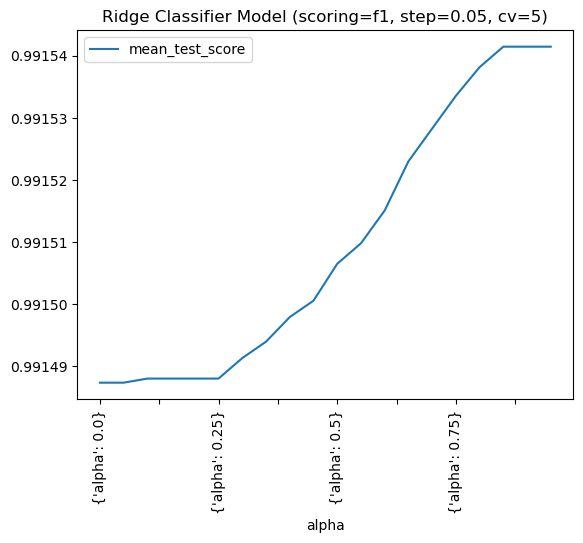

In [22]:
results = pd.DataFrame(ridge_model1.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
results.plot(x = 'params', y = 'mean_test_score')
plt.title('Ridge Classifier Model (scoring=f1, step=0.05, cv=5)')
plt.xticks(rotation = 90)
plt.xlabel('alpha')
plt.show()

In [23]:
# top 20 feature coefficients
feature_coef = pd.DataFrame({'feature':ridge_model1.feature_names_in_,'coef':ridge_model1.best_estimator_.coef_[0]})
feature_coef['abs_coef'] = abs(feature_coef['coef'])
feature_coef.sort_values(by = 'abs_coef', ascending = False).head(20)

,feature,coef,abs_coef
94,BorrowerState_AS,-1.346958,1.346958
127,BorrowerState_NV,-1.342938,1.342938
95,BorrowerState_AZ,-1.332372,1.332372
140,BorrowerState_UT,-1.331749,1.331749
144,BorrowerState_WA,-1.331317,1.331317
104,BorrowerState_HI,-1.330854,1.330854
113,BorrowerState_MD,-1.330803,1.330803
98,BorrowerState_CT,-1.329536,1.329536
121,BorrowerState_NC,-1.326266,1.326266
103,BorrowerState_GU,-1.325848,1.325848


In [24]:
# param_grid alpha values
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.05)

ridge = RidgeClassifier()
ridge_model2 = GridSearchCV(ridge, param_grid=grid, scoring='recall', cv = 10)
ridge_model2.fit(X_train_resampled, y_train_resampled)

# predict y values based on lasso model
y_pred = ridge_model2.predict(X_test)

# generate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

print(f"Alpha: {ridge_model2.best_params_}")
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_report_result}')
print()
print(confusion_matrix(y_test, y_pred))

c:\Users\wei-z\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.66006e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\wei-z\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.66423e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\wei-z\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.66297e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: {'alpha': 0.8500000000000001}
Accuracy: 0.9975569058992926
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    192287
           1       0.14      0.84      0.25        92

    accuracy                           1.00    192379
   macro avg       0.57      0.92      0.62    192379
weighted avg       1.00      1.00      1.00    192379


[[191832    455]
 [    15     77]]


In [25]:
# save model
joblib.dump(ridge_model2, 'ridge_model_recall.pkl')

['ridge_model_recall.pkl']

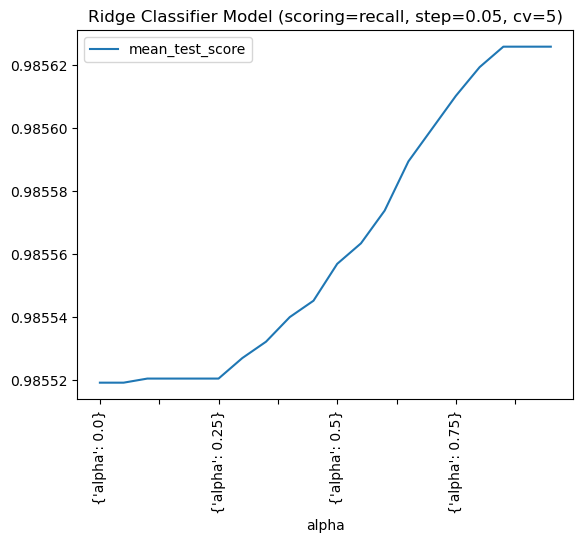

In [26]:
results = pd.DataFrame(ridge_model2.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]

results.plot(x = 'params', y = 'mean_test_score')
plt.title('Ridge Classifier Model (scoring=recall, step=0.05, cv=5)')
plt.xticks(rotation = 90)
plt.xlabel('alpha')
plt.show()

In [27]:
# top 20 feature coefficients
feature_coef = pd.DataFrame({'feature':ridge_model2.feature_names_in_,'coef':ridge_model2.best_estimator_.coef_[0]})
feature_coef['abs_coef'] = abs(feature_coef['coef'])
feature_coef.sort_values(by = 'abs_coef', ascending = False).head(20)

,feature,coef,abs_coef
94,BorrowerState_AS,-1.346958,1.346958
127,BorrowerState_NV,-1.342938,1.342938
95,BorrowerState_AZ,-1.332372,1.332372
140,BorrowerState_UT,-1.331749,1.331749
144,BorrowerState_WA,-1.331317,1.331317
104,BorrowerState_HI,-1.330854,1.330854
113,BorrowerState_MD,-1.330803,1.330803
98,BorrowerState_CT,-1.329536,1.329536
121,BorrowerState_NC,-1.326266,1.326266
103,BorrowerState_GU,-1.325848,1.325848


### Lasso Hyperparameter Tuning

In [28]:
# param_grid alpha values
grid = {'alpha': np.arange(0, 1, 0.05)}
# grid['alpha'] = np.arange(0, 1, 0.05)

lasso = Lasso()
lasso_model = GridSearchCV(lasso, param_grid=grid, scoring='neg_mean_absolute_error', cv = 10)
lasso_model.fit(X_train_resampled, y_train_resampled)

# predict y values based on lasso model
y_pred = lasso_model.predict(X_test)

# note that prediction output is 0 < y < 1, hence convert into binary
y_pred_binary = [1 if i > 0.5 else 0 for i in y_pred]

# generate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred_binary)
classification_report_result = classification_report(y_test, y_pred_binary)

print(f"Alpha: {lasso_model.best_params_}")
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_report_result}')
print()
print(confusion_matrix(y_test, y_pred_binary))

c:\Users\wei-z\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\wei-z\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\wei-z\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.458e+03, tolerance: 3.418e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = 

Alpha: {'alpha': 0.0}
Accuracy: 0.9975569058992926
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    192287
           1       0.14      0.84      0.25        92

    accuracy                           1.00    192379
   macro avg       0.57      0.92      0.62    192379
weighted avg       1.00      1.00      1.00    192379


[[191832    455]
 [    15     77]]


In [29]:
# save model
joblib.dump(lasso_model, 'lasso_model.pkl')

['lasso_model.pkl']

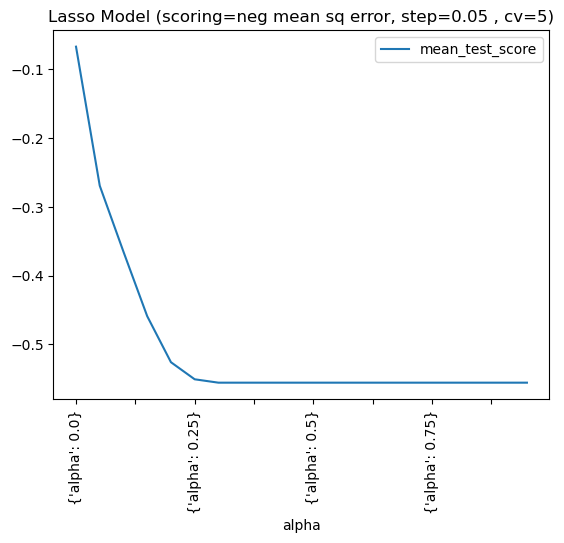

In [30]:
results = pd.DataFrame(lasso_model.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]

results.plot(x = 'params', y = 'mean_test_score')
plt.title('Lasso Model (scoring=neg mean sq error, step=0.05 , cv=5)')
plt.xticks(rotation = 90)
plt.xlabel('alpha')
plt.show()

In [31]:
# top 20 feature coefficients
feature_coef = pd.DataFrame({'feature':lasso_model.feature_names_in_,'coef':lasso_model.best_estimator_.coef_})
feature_coef['abs_coef'] = abs(feature_coef['coef'])
feature_coef.sort_values(by = 'abs_coef', ascending = False).head(20)

,feature,coef,abs_coef
25,Race_Eskimo & Aleut,-0.876960,0.876960
94,BorrowerState_AS,-0.709853,0.709853
127,BorrowerState_NV,-0.672158,0.672158
118,BorrowerState_MP,-0.666999,0.666999
95,BorrowerState_AZ,-0.666834,0.666834
140,BorrowerState_UT,-0.666559,0.666559
144,BorrowerState_WA,-0.666291,0.666291
104,BorrowerState_HI,-0.666172,0.666172
113,BorrowerState_MD,-0.666041,0.666041
142,BorrowerState_VI,-0.665441,0.665441
